# Определение стоимости автомобилей

**Цель проекта - создание модели регрессии, наилучшим образом предсказывающую цену автомобиля.**

**При этом важными показателями остаются время предсказания и обучения модели.**

**Задачей проекта в рамках курса является отработка навыков работы с CatBoost и аналогичными библиотеками, однако, для полноты исследования будут также применены более простые модели.**

`Целевая метрика предсказаний - RMSE.`

In [ ]:
RANDOM_STATE = 42

## Описание признаков

Признаки

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    Repaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

Целевой признак
**Price** — цена (евро)

In [ ]:
!pip install CatBoost
!pip install lightgbm
!pip install phik


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from phik import phik_matrix
from catboost import CatBoostRegressor

## Загрузка датасета и первичный анализ данных

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', parse_dates=True)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(9)
me

## Предобработка

In [ ]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
df['DateCrawled'].min()

Timestamp('2016-03-05 14:06:22')

**Исходя из того, что даты сбора данных ограничиваются 2016 годом, можно считать, что даты регистрации автомобилей после 2017ого года включительно представляют из себя аномалии**

In [ ]:
# Проверим неявные дубликаты
df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [ ]:
# Обработаем Nan в столбцах и приведём данные к нужному типу
df = df.fillna({'VehicleType': 'other'})
df = df[(df['RegistrationYear'] >= 1900) & (df['RegistrationYear'] <= 2017)]
df = df[df['Power'] <= 1100]
df = df.fillna({'Gearbox': 'other'})
df = df.fillna({'Model': 'other'})
df = df.fillna({'FuelType': 'other'})
df = df.fillna({'Repaired': 'NotStated'})
df['FuelType'] = df['FuelType'].str.replace('petrol', "gasoline", case=False, regex=False)

for column in ['DateCrawled', 'DateCreated', 'LastSeen']:
    df[column] = pd.to_datetime(df[column])

del df['RegistrationMonth']

# Модель не должна воспринимать почтовый индекс как числовой столбец т.к.
# индекс формируется в зависимости от кода региона и прочих геоданных.
df['PostalCode'] = df['PostalCode'].astype('object')

# Удаляем объявления с нулевой ценой и мощностью
df = df[(df['Power'] != 0) & (df['Price'] != 0)]

## Сжатие датафрейма


In [ ]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                            .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

df = optimize_memory_usage(df, True)

Размер использования памяти: до 37.12 Mb - после 28.71 Mb (22.7%)


## Анализ корреляций

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'NumberOfPictures']


c:\Users\Nitro\AppData\Local\Programs\Python\Python39\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable NumberOfPictures for analysis 1. Dropping this column
  warnings.warn(


<Axes: >

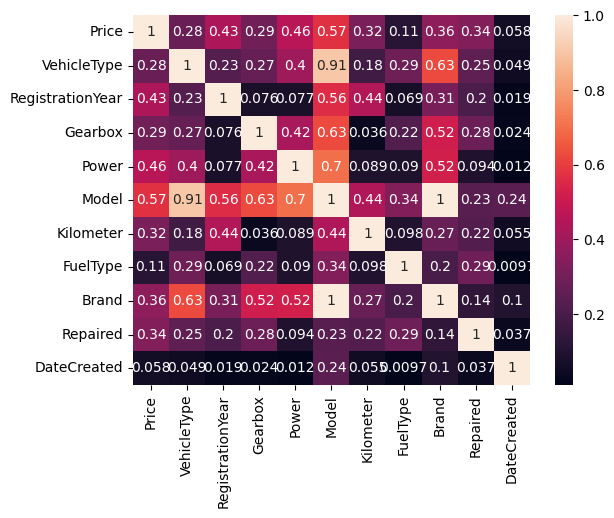

In [ ]:
sns.heatmap(
    df.drop(['DateCrawled', 'LastSeen', 'PostalCode'], axis=1).phik_matrix(),
    annot=True)

**Есть корреляция между входными признаками в парах:**

`Brand - Model (1.00)`

`VehicleType - Model (0.90)`

**Вероятно, следует удалить столбец model, к этому решению так же подводит количество уникальных значений в столбце (250) и, как следствие, увеличение размерности при кодировании этого столбца, что критично в рамках работы со сложными моделями**

In [ ]:
del df['Model']

## Моделирование

In [ ]:
X = df[[
#    'DateCrawled',
    'VehicleType',
    'RegistrationYear',
    'Gearbox',
    'Power',
#    'Model',
    'Kilometer',
#    'RegistrationMonth',
    'FuelType',
    'Brand',
    'Repaired',
#    'DateCreated',
#    'PostalCode',
#    'LastSeen'
]
]

y = df['Price']

In [ ]:
num_cols = X.select_dtypes(include='number').columns
cat_cols = X.select_dtypes(include='object').columns

X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category'))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RANDOM_STATE
    )

C:\Users\Nitro\AppData\Local\Temp\ipykernel_8056\2624649115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category'))


In [ ]:
# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RANDOM_STATE
)

# Определение трансформера для предварительной обработки данных
col_transformer = ColumnTransformer([
    ('OHE', OneHotEncoder(), cat_cols),
    ('RS', RobustScaler(), num_cols)
])

# Определение пайплайна
pipe = Pipeline([
    ('preprocessor', col_transformer),
    ('model', CatBoostRegressor(random_state=RANDOM_STATE))
])

# Определение параметров для перебора
param_grid = [
    {
        'model': [LinearRegression()]
    },
    {
        'model': [LGBMRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1, 0.3]
    },
    {
        'model': [CatBoostRegressor(verbose=0, random_state=RANDOM_STATE, cat_features=cat_cols)],
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1, 0.3]
    }
]

In [ ]:
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best model:", best_model)
print("Best parameters:", grid_search.best_params_)

c:\Users\Nitro\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 65.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nitro\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nitro\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Nitro\AppData\Local\Programs\Python\Python39\lib\site-p

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 465
[LightGBM] [Info] Number of data points in the train set: 203721, number of used features: 63
[LightGBM] [Info] Start training from score 4821.822880
Best model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OHE', OneHotEncoder(),
                                                  Index(['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired'], dtype='object')),
                                                 ('RS', RobustScaler(),
                                                  Index(['RegistrationYear', 'Power', 'Kilometer'], dtype='object'))])),
                ('model',
                 LGBMRegressor(learning_rate=0.3, n_estimators=200,
                               random_state=42))])

In [ ]:
preds = best_model.predict(X_test)
mean_squared_error(preds, y_test)**.5

1655.0644618073754

In [ ]:
# Находим среднее время обучения и предсказания для всех моделей
print(f"среднее время обучения = {grid_search.cv_results_['mean_fit_time'].mean()}")
print(f"среднее время предсказания = {grid_search.cv_results_['mean_score_time'].mean()}")

# Находим время работы лучшей модели
data = [
    'mean_fit_time',
    'mean_score_time',
    'params'
]
time_results = [grid_search.cv_results_[key] for key in data]
print('Данные лучшей модели:')
for i in range(len(time_results)):
    print(time_results[i][6])

среднее время обучения = 4.57233021075909
среднее время предсказания = 0.07543081503648025
Данные лучшей модели:
6.788972425460815
0.13140087127685546
{'model': LGBMRegressor(learning_rate=0.3, n_estimators=200, random_state=42), 'model__learning_rate': 0.3, 'model__n_estimators': 200}


**Время обучения лучшей модели выше среднего по всем этапам кросс-валидации, однако ненамного**

# Итоги

**Предобработка**

В процессе предобработки данных были заменены Nan, изменены типы данных некоторых столбцов.

Несмотря на удаление столбцов с датами и почтовыми индексами, модель показывает хорошую RMSE, явно ниже указанного порога в 2500.

**Анализ корреляций**

В ходе анализа хитмапа матрицы phik была найдена корреляция в парах:

`Brand - Model (1.00)`

`VehicleType - Model (0.90)`

Принято решение об удалении столбца с моделью, за исключением корреляции с входными признаками,

столбец содержит много уникальных значений, что может привести к переобучению сложных моделей.

**Моделирование**

Была проведена кросс-валидация по сетке, использовались модели: обыкновенная линейная регрессия sklearn, LightGBM Regressor и CatBoost Regressor.

По итогам кросс-валидации была выбрана модель LGBM с RMSE ~= 1760.